### In this notebook we continue talk about dataset. Now we'll knows, how we can create a neual network and  train it on MNIST.  And check, how neual network reacts to displacement.
How the inplenet class with neual network you'll see [here](https://github.com/analysiscenter/az_training/blob/anton_broilovskiy/task_02/my_batch.py). Impelentation of build blocks to neual network [here](https://github.com/analysiscenter/az_training/blob/anton_broilovskiy/task_02/layers.py). 

In [1]:
import sys

import os
import blosc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline

sys.path.append('..')
import utils
from my_batch import MnistBatch
from dataset import DatasetIndex, Dataset

On this example we load all the data in memory, and after it we load this data into the Dataset model. But this is not nesessery, you can create dataset and load data at once into batch. Read [this](https://github.com/analysiscenter/dataset/blob/master/doc/batch.md) to more understanding.

In [2]:
src = '../MNIST_data/'
with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())

In [3]:
src = (full_imgs, full_labs)

First of all, we need to create [index](https://github.com/analysiscenter/dataset/blob/master/doc/index.md). In our case, the index is a list of indexes, because we know the length of the data set and can iterate on it.

In [4]:
LEN_MNIST = 65000
indy = DatasetIndex(np.arange(LEN_MNIST))

Now create dataset, on our indices and batch class MnistBatch. The same actions we did in the previous notebook.

In [5]:
mnistset = Dataset(indy, batch_class=MnistBatch)
mnistset.cv_split([0.9, 0.1])

As we know, to train tensorflow model, we need tensorflow session.

In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Already familiar to us the construction to create the pipelines. Note, that in this time we have a load function, that load data in batch, but the rest of the design remained the same. This pipelines train NN on simple MNIST images, without shift.

In [7]:
stats = []
ppl_train = (mnistset.train.pipeline()
       .load(src=src, fmt='ndarray')
       .train_convy(sess))

ppl_test = (mnistset.test.pipeline()
            .load(src=src, fmt='ndarray')
            .update_stats(sess, stats))

There are many ways to train pipeline, in this time, we using next_batch. If you want to see all methods, welcome [here](https://github.com/analysiscenter/dataset/blob/master/doc/pipeline.md).

In [8]:
for i in tqn(range(800)):
    ppl_train.next_batch(100, n_epochs=None)
    ppl_test.next_batch(100, n_epochs=None)

Widget Javascript not detected.  It may not be installed or enabled properly.


../utils.py:24: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(fitst), span=window, adjust=False)


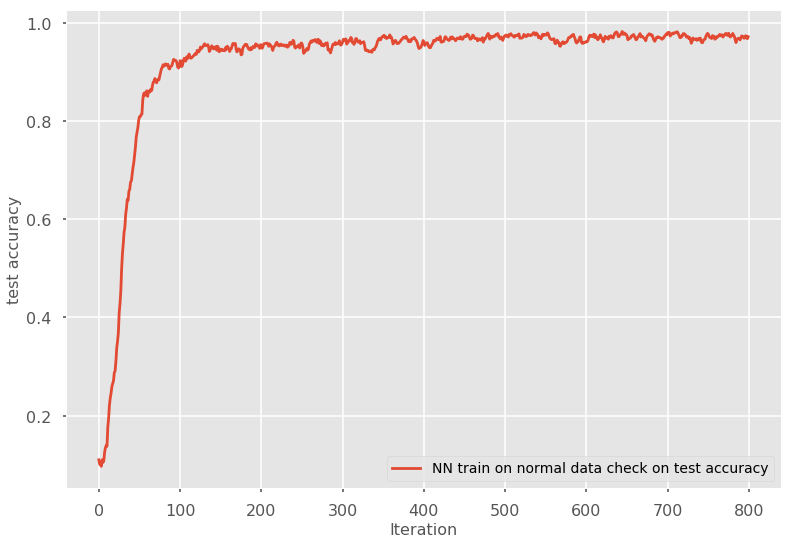

In [10]:
utils.draw(stats,'NN train on normal data check on', type_data='test accuracy', window=10)

Now check, how change accuracy, if we test first model on shift data with parallel computing. In some case operations on data might be very difficult and take a lot of time. To reduce runtime you can use [parallelism](https://github.com/analysiscenter/dataset/blob/master/doc/parallel.md).

In [11]:
dict_p = {'predict': [],
          'answer': [],
          'imgs': []}
pred_sh =[]
answer_sh = []
imgs_sh = []
(mnistset.test
    .p
    .load(src=src, fmt='ndarray')
    .shift_flattened_pic()
    .prediction(sess, dict_p)
    .run(1, n_epochs=1))

In [12]:
print('Accuracy with shift: ', np.sum(dict_p['answer'])/len(dict_p['predict']))

Accuracy with shift:  0.513076923077


Now let's see, now change accuracy, if we continue train model, but do it on train data.

In [13]:
ppl_shift_train = (mnistset.train.pipeline()
       .load(src=src, fmt='ndarray')
       .shift_flattened_pic()
       .train_convy(sess))
for i in tqn(range(800)):
    ppl_shift_train.next_batch(100, n_epochs=None)

Widget Javascript not detected.  It may not be installed or enabled properly.


And now check, how change accuracy on shift data

In [14]:
dict_p = {'predict': [],
          'answer': [],
          'imgs': []}
pred_sh =[]
answer_sh = []
imgs_sh = []
(mnistset.test
    .p
    .load(src=src, fmt='ndarray')
    .shift_flattened_pic()
    .prediction(sess, dict_p)
    .run(1, n_epochs=1))

In [15]:
print('Accuracy with shift: ', np.sum(dict_p['answer'])/len(dict_p['predict']))

Accuracy with shift:  0.918307692308


It's really better, than before.

Iteresting on what numbers we are wrong?

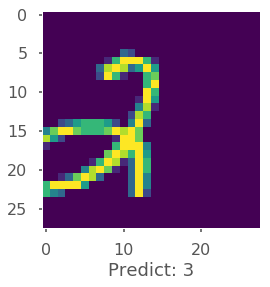

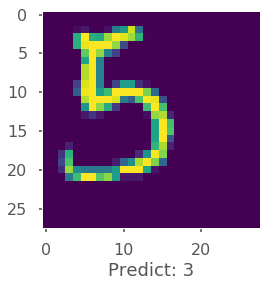

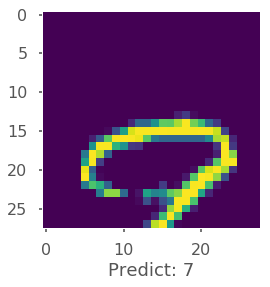

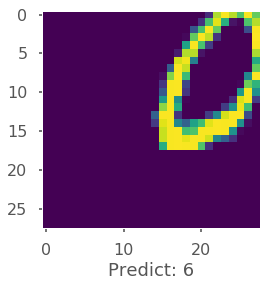

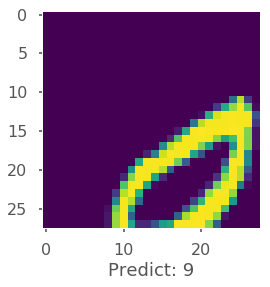

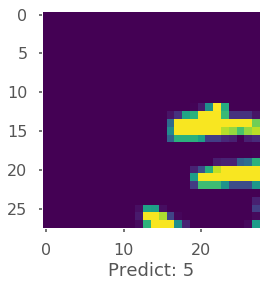

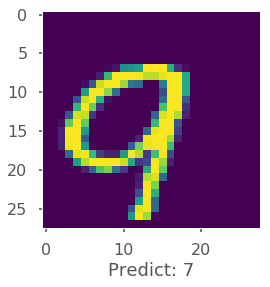

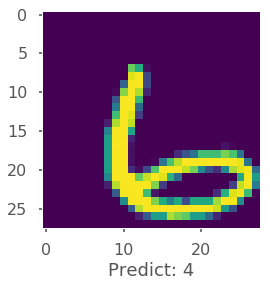

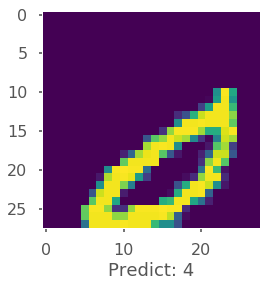

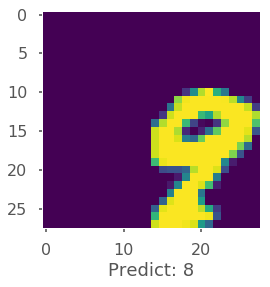

In [16]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,4)

for i in range(10):
    fig = plt.figure()
    index = np.where(np.array(dict_p['answer']).reshape(-1) == False)[0][i]
    plt.imshow(dict_p['imgs'][index].reshape(-1,28))
    plt.xlabel('Predict: {}'.format(np.argmax(dict_p['predict'][index])), fontsize=18)
    plt.grid()

In most cases, the model is mistaken for examples in which the figures are heavily shifted, some of them are even hardly recognizable by eye.